In [1]:
import pandas as pd
pd.set_option('display.max_columns', None)

import numpy as np

import geopandas as gpd
import fiona

import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
counties = pd.read_excel('covid-recovery-data.xlsx', sheet_name="county-population")
jobs = pd.read_excel('covid-recovery-data.xlsx', sheet_name="county-jobs-summary", usecols="B,C,D,F,G,I")
ccvi = pd.read_excel('covid-recovery-data.xlsx', sheet_name="ccvi-county", usecols="D:K")
countyShape = gpd.read_file("spatial/ga-counties.geojson")
countyClaims = pd.read_excel('covid-recovery-data.xlsx', sheet_name="unemployment-claims-monthly")
hospitals = gpd.read_file("spatial/hospitals.geojson")

In [3]:
hospitals = gpd.read_file("spatial/hospitals.geojson")

In [4]:
hospitals.sort_values('BEDS', inplace=True)

In [5]:
hospitals.BEDS = np.where(hospitals.BEDS < 0, 82,hospitals.BEDS)

In [6]:
counties = pd.merge(counties,jobs,how='left',on='FIPS')

In [7]:
counties = pd.merge(counties,ccvi,how='left',on='FIPS')

In [8]:
counties['FIPS'] = counties['FIPS'].astype(str)

In [9]:
counties = pd.merge(counties,countyShape, how='left', left_on='FIPS', right_on='GEOID')

In [10]:
del counties['GEOID']

In [11]:
# groupby county fips to get number of hospitals and number of beds per county
countyHospitals = hospitals.groupby('COUNTYFIPS') \
                           .agg({'NAME':'count', 'BEDS': 'sum'}) \
                           .reset_index() \
                           .rename(columns={'NAME':'Hospitals',
                                            'BEDS':'Beds',
                                            'COUNTYFIPS':'FIPS'})

In [12]:
counties = pd.merge(counties,countyHospitals, how='left', on='FIPS')

In [13]:
counties['Hospitals'].fillna(0, inplace=True)
counties['Beds'].fillna(0, inplace=True)

In [14]:
counties['Beds_per_1000'] = ( counties['Beds'] / counties['Total_Population'] ) * 1000
counties['Beds_per_1000_Elderly'] = ( counties['Beds'] / counties['Population_Over_65'] ) * 1000

In [15]:
covid = pd.read_csv('https://raw.githubusercontent.com/nytimes/covid-19-data/master/us-counties.csv')
covid = covid.loc[covid['state'] == 'Georgia']

In [16]:
# the covid data is reported as a cumulative sum
# we want the daily counts as well for different charting options
covid.date = pd.to_datetime(covid.date)
covid.sort_values(['county', 'date'], ascending=[True, True], inplace=True)

In [17]:
covid['fips'] = covid['fips'].fillna(13)

In [18]:
covid['fips'] = covid['fips'].astype(int)
covid['fips'] = covid['fips'].astype(str)

In [19]:
covid.reset_index(inplace=True, drop=True)

In [20]:
covid.sort_values(['county', 'date'], ascending=[True, True], inplace=True)

In [21]:
covid['daily_cases'] = np.where(covid.fips == covid.fips.shift(), covid.cases - covid.cases.shift(), np.nan)

In [22]:
covid['daily_cases'].fillna(covid['cases'], inplace=True)

In [23]:
covid['daily_deaths'] = np.where(covid.fips == covid.fips.shift(), covid.deaths - covid.deaths.shift(), np.nan)
covid['daily_deaths'].fillna(covid['deaths'], inplace=True)

In [ ]:
# add 7 day running average
# add total new cases last two weeks
# add total new cases per 1000
# add daily growth rate over last 14 days
# new cases over the last 7 days
# new cases over the previous 7-day period
# total change current week to previous week
# week to week change per 100k

# remake these charts in datawrapper https://www.nytimes.com/interactive/2020/04/23/upshot/five-ways-to-monitor-coronavirus-outbreak-us.html
    
# add these summed datapoints to the county flat file and push to mapbox

# add these new features to the current application

In [24]:
# groupby county fips to get number of hospitals and number of beds per county
covidTotals = covid.groupby('fips') \
                   .agg({'daily_cases':'sum', 'daily_deaths': 'sum'}) \
                   .reset_index() \
                   .rename(columns={'daily_cases':'Cases',
                                    'daily_deaths':'Deaths',
                                    'fips':'FIPS'})

In [27]:
covidTotals['FIPS'] = covidTotals['FIPS'].astype(str)

In [28]:
# merge counties with covid
counties = pd.merge(counties,covidTotals, how='left', on='FIPS')

In [29]:
counties['Cases'].fillna(0, inplace=True)
counties['Deaths'].fillna(0, inplace=True)

In [30]:
# add custom columns on rates, etc.
counties['COVID_Death_Rate'] = ( counties['Deaths'] / counties['Cases'] ) * 100
counties['COVID_Cases_Per_1000'] = ( counties['Cases'] / counties['Total_Population'] ) * 1000

In [31]:
countyClaims = countyClaims.melt(id_vars=["FIPS", "County","Year"], var_name="Month", value_name="Claims")

In [32]:
countyClaimsNew = countyClaims.loc[countyClaims['Year'] == 2020]
countyClaimsNew = countyClaimsNew.loc[countyClaimsNew['Month'] == "March"]
countyClaimsLast = countyClaims.loc[countyClaims['Year'] == 2020]
countyClaimsLast = countyClaimsLast.loc[countyClaimsLast['Month'] == "February"]

claims = pd.merge(countyClaimsNew, countyClaimsLast, how='left', on='FIPS')

In [36]:
claims.rename(columns={'Claims_x' : 'March_Claims',
                       'Claims_y' : 'February_Claims'}, inplace=True)

claims['Claims_Pct_Change'] = ( ( claims['March_Claims'] - claims['February_Claims'] ) / claims['February_Claims'] ) * 100

In [37]:
claims['Claims_Pct_Change'] = claims['Claims_Pct_Change'].round(1)

In [38]:
claims['FIPS'] = claims['FIPS'].astype(str)

In [39]:
claims = claims[['FIPS','March_Claims','February_Claims','Claims_Pct_Change']]

In [40]:
claims.sort_values('February_Claims', inplace=True)

In [41]:
counties = pd.merge(counties, claims, how='left', on='FIPS')

In [42]:
counties.sort_values('February_Claims', inplace=True)

In [43]:
counties['Cases_1000_Norm'] = (counties.iloc[ : , 29 ]-counties.iloc[ : , 29 ].min())/(counties.iloc[ : , 29 ].max()-counties.iloc[ : , 29 ].min()) * 100

In [44]:
counties = counties[['FIPS','County','Total_Population','Population_Under_18','Population_Over_18','Population_Over_65',
                     'Population_Pct_Over_65','Jobs','Jobs_Frequent_Disease_Exposure','Jobs_Pct_Disease_Exposure',
                     'Jobs_Frequent_Physical_Proximity','Jobs_Pct_Prox','Socioeconomic_Status',
                     'Household_Comp_Disability','Minority_Status_Language','Housing_Transportation',
                     'Epidemiology','Healthcare_System','CCVI_Score','Hospitals','Beds','Beds_per_1000','Pct_Uninsured',
                     'Beds_per_1000_Elderly','Cases','Deaths','COVID_Death_Rate','COVID_Cases_Per_1000','Cases_1000_Norm',
                     'March_Claims','February_Claims','Claims_Pct_Change','geometry']]

In [45]:
counties = gpd.GeoDataFrame(counties, geometry='geometry')

In [46]:
countyPoints = counties.copy()

In [47]:
countyPoints['geometry'] = counties['geometry'].centroid

In [48]:
countyPoints.sort_values('Cases_1000_Norm', inplace=True)
countyPoints['Cases_1000_Norm'].round(1)
counties['COVID_Death_Rate'].fillna(0, inplace=True)
countyPoints['COVID_Death_Rate'].fillna(0, inplace=True)

In [49]:
countyData = counties[['FIPS','County','Cases','Deaths','Total_Population','Population_Under_18','Population_Over_18','Population_Over_65',
                     'Population_Pct_Over_65','Jobs','Jobs_Frequent_Disease_Exposure','Jobs_Pct_Disease_Exposure',
                     'Jobs_Frequent_Physical_Proximity','Jobs_Pct_Prox','Socioeconomic_Status',
                     'Household_Comp_Disability','Minority_Status_Language','Housing_Transportation',
                     'Epidemiology','Healthcare_System','CCVI_Score','Hospitals','Beds','Beds_per_1000','Pct_Uninsured',
                     'Beds_per_1000_Elderly','COVID_Death_Rate','COVID_Cases_Per_1000','Cases_1000_Norm',
                     'March_Claims','February_Claims','Claims_Pct_Change']]

In [50]:
hospitals.to_excel('hospitals.xlsx',index=False)

In [51]:
countyHospitals.to_excel('hospitals.xlsx',index=False)

In [52]:
hospitals = hospitals[['ID','NAME','ADDRESS','CITY','STATE','ZIP','TYPE','STATUS','COUNTY','COUNTYFIPS',
                       'LATITUDE','LONGITUDE','NAICS_CODE','NAICS_DESC','BEDS','TRAUMA',
                       'HELIPAD','geometry']]

In [53]:
hospitals.to_file("spatial/mapbox/hospitals.geojson", driver='GeoJSON')

In [55]:
counties.to_file("spatial/mapbox/countyData.geojson", driver='GeoJSON')
countyPoints.to_file("spatial/mapbox/countyPoints.geojson", driver='GeoJSON')
countyData.to_excel('countyData.xlsx', index=False)
covid.to_excel('covid.xlsx', index=False)

In [56]:
countyData.sort_values('Cases',inplace=True)

C:\Users\MTMAINZE\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


,FIPS,County,Cases,Deaths,Total_Population,Population_Under_18,Population_Over_18,Population_Over_65,Population_Pct_Over_65,Jobs,Jobs_Frequent_Disease_Exposure,Jobs_Pct_Disease_Exposure,Jobs_Frequent_Physical_Proximity,Jobs_Pct_Prox,Socioeconomic_Status,Household_Comp_Disability,Minority_Status_Language,Housing_Transportation,Epidemiology,Healthcare_System,CCVI_Score,Hospitals,Beds,Beds_per_1000,Pct_Uninsured,Beds_per_1000_Elderly,COVID_Death_Rate,COVID_Cases_Per_1000,Cases_1000_Norm,March_Claims,February_Claims,Claims_Pct_Change
154,13135,Gwinnett County,1124.0,38.0,902298,247451,654847,83442,9.247721,407959.281641,13421.062658,3.289804,72398.271894,17.746446,0.328239,0.054441,0.962114,0.049984,0.100605,0.126393,0.101878,6.0,929.0,1.029593,16.841332,11.133482,3.380783,1.245708,6.130787,29768,1447,1957.2
155,13067,Cobb County,1148.0,54.0,745057,180207,564850,85117,11.424227,407114.511371,15716.328766,3.860420,73047.985512,17.942860,0.165234,0.056988,0.886342,0.041388,0.194524,0.159185,0.085960,6.0,1274.0,1.709936,12.210475,14.967633,4.703833,1.540822,7.583197,26415,1228,2051.1
156,13095,Dougherty County,1425.0,90.0,91049,22101,68948,13321,14.630584,52505.065419,3180.433026,6.057383,11361.299438,21.638483,0.848138,0.780643,0.796880,0.524355,0.880611,0.523719,0.872970,2.0,939.0,10.313128,11.394963,70.490203,6.315789,15.650913,77.026404,2663,266,901.1
157,13089,DeKalb County,1473.0,24.0,743187,174266,568921,85571,11.514060,342656.967297,17976.739607,5.246279,65062.890941,18.987762,0.472143,0.126393,0.919452,0.371219,0.352436,0.164597,0.335880,15.0,2686.0,3.614164,13.893139,31.389139,1.629328,1.982005,9.754490,27027,1588,1602.0
158,13121,Fulton County,2131.0,75.0,1021902,230272,791630,113402,11.097150,955995.220840,44057.581711,4.608557,165477.867472,17.309487,0.260745,0.102197,0.863738,0.249920,0.983126,0.156638,0.420885,19.0,4984.0,4.877180,11.405693,43.949842,3.519474,2.085327,10.262996,44097,2215,1890.8


In [57]:
# for correlations
dataPlot = counties[['County','Population_Over_65',
                     'Population_Pct_Over_65','Jobs','Jobs_Frequent_Disease_Exposure','Jobs_Pct_Disease_Exposure',
                     'Jobs_Frequent_Physical_Proximity','Jobs_Pct_Prox','Socioeconomic_Status',
                     'Epidemiology','Healthcare_System','CCVI_Score','Hospitals','Beds','Beds_per_1000','Pct_Uninsured',
                     'Beds_per_1000_Elderly','COVID_Death_Rate','COVID_Cases_Per_1000','Cases_1000_Norm',
                     'Claims_Pct_Change']]

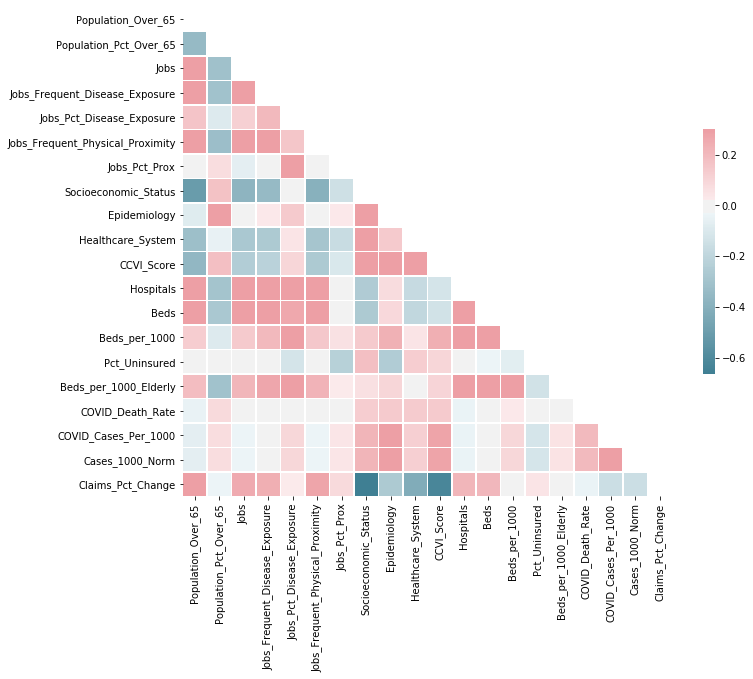

In [58]:
# Compute the correlation matrix
corr = dataPlot.corr()

# Generate a mask for the upper triangle
mask = np.triu(np.ones_like(corr, dtype=np.bool))

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(220, 10, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

In [59]:
plt.show()